In [12]:
import jax
import jraph
import flax
import jax.numpy as jnp
import networkx as nx
from typing import NamedTuple

In [3]:
@flax.struct.dataclass
class GraphState:
    nodes: jnp.array
    edges: jnp.array
    senders: jnp.array
    receivers: jnp.array
    n_node: jnp.array
    n_edge: jnp.array
    globals: jnp.array

    def to_dict(self) -> dict:
        return {
            field.name: getattr(self, field.name)
            for field in flax.struct.dataclasses.fields(self)
        }


class NeatNetwork:
    @staticmethod
    def build_network(graph_state: GraphState):
        return jraph.GraphsTuple(**graph_state.to_dict())

    @staticmethod
    def plot_network(jraph_graph: jraph.GraphsTuple) -> None:
        def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
            nodes, edges, receivers, senders, _, _, _ = jraph_graph
            nx_graph = nx.DiGraph()
            if nodes is None:
                for n in range(jraph_graph.n_node[0]):
                    nx_graph.add_node(n)
            else:
                for n in range(jraph_graph.n_node[0]):
                    nx_graph.add_node(n, node_feature=nodes[n])
            if edges is None:
                for e in range(jraph_graph.n_edge[0]):
                    nx_graph.add_edge(int(senders[e]), int(receivers[e]))
            else:
                for e in range(jraph_graph.n_edge[0]):
                    nx_graph.add_edge(
                        int(senders[e]), int(receivers[e]), edge_feature=edges[e]
                    )
            return nx_graph

        nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
        pos = nx.spring_layout(nx_graph)
        nx.draw(nx_graph, pos=pos, with_labels=True, node_size=500, font_color="yellow")

In [4]:
node_features = jnp.array([[0.], [2.], [4.], [6.]])
senders = jnp.array([0, 1, 2, 3, 0])
receivers = jnp.array([1, 2, 0, 0, 3])
edges = jnp.array([[5.], [6.], [7.], [8.], [8.]])
n_node = jnp.array([4])
n_edge = jnp.array([5])
global_context = jnp.array([[1]])

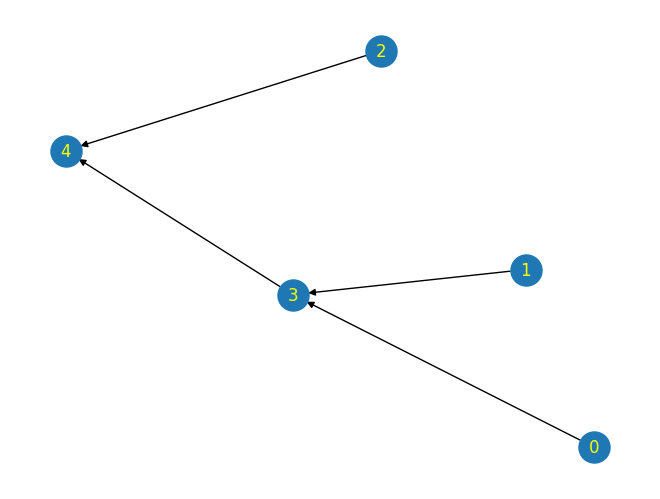

In [5]:
neat_net = NeatNetwork()

node_features = jnp.ones(5)
senders = jnp.array([0,1,2,3])
receivers = jnp.array([3,3,4,4])
edges = jnp.ones(4)
n_node = jnp.array([5])
n_edge = jnp.array([4])
global_context = jnp.array([[1]])

graph_state = GraphState(
    node_features, edges, senders, receivers, n_node, n_edge, global_context
)
network = neat_net.build_network(graph_state)
neat_net.plot_network(network)

In [13]:
class Node(NamedTuple):
    index: jnp.int32
    type: jnp.int32
    enabled: jnp.bool_
    activated: jnp.bool_

class Network(NamedTuple):
    nodes: list[Node]
    edges: jnp.ndarray
    senders: jnp.ndarray
    receivers: jnp.ndarray

@staticmethod
def plot_network(net: Network) -> None:
    def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
        nodes, edges, receivers, senders, _, _, _ = jraph_graph
        nx_graph = nx.DiGraph()
        if nodes is None:
            for n in range(jraph_graph.n_node[0]):
                nx_graph.add_node(n)
        else:
            for n in range(jraph_graph.n_node[0]):
                nx_graph.add_node(n, node_feature=nodes[n])
        if edges is None:
            for e in range(jraph_graph.n_edge[0]):
                nx_graph.add_edge(int(senders[e]), int(receivers[e]))
        else:
            for e in range(jraph_graph.n_edge[0]):
                nx_graph.add_edge(
                    int(senders[e]), int(receivers[e]), edge_feature=edges[e]
                )
        return nx_graph

    nx_graph = convert_jraph_to_networkx_graph(net)
    pos = nx.spring_layout(nx_graph)
    nx.draw(nx_graph, pos=pos, with_labels=True, node_size=500, font_color="yellow")

In [14]:
n_nodes = 5
nodes = jax.vmap(Node)(
    jnp.arange(n_nodes),
    jnp.array([1, 1, 1, 2, 3]),
    jnp.ones(n_nodes),
    jnp.array([1, 1, 1, 0, 0]),
)
net = Network(
    nodes,
    edges=jnp.ones(n_nodes - 1),
    senders=jnp.array([0,1,2,3]),
    receivers=jnp.array([3,3,4,4]),
)

In [ ]:
# compute input activations
# if neurons are fully activated, compute activation
# 
#
#
#

In [94]:
def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))


def node_update_fn(nodes, received_edges_sum, sent_edges_sum, globals_):
    # Node update function: applies the sigmoid activation 
    # function to the sum of received edge attributes.
    return sigmoid(received_edges_sum)


def edge_update_fn(edges, sender_nodes, receiver_nodes, globals_):
    # Edge update function: simply returns the edges as they are, 
    # in this case they are just weights.
    return edges


# Define your graph using jraph.GraphsTuple
graph = jraph.GraphsTuple(
    nodes=jnp.array(
        [0.5, 0.8, 0.2, 0, 0] 
    ),  # Example inputs for nodes 0, 1, and 2; others are 0.
    senders=jnp.array([0, 1, 2, 3]),  # Senders (source nodes of edges)
    edges=jnp.array([1, 1, 1, 1]),  # Edge weights
    receivers=jnp.array([3, 3, 4, 4]),  # Receivers (target nodes of edges)
    globals=jnp.array([0]),  # Global state of the graph (if any)
    n_node=jnp.array([5]),  # Number of nodes
    n_edge=jnp.array([4]),  # Number of edges
)

# Apply the node and edge update functions using the GraphNetwork.
graph_network = jraph.GraphNetwork(
    update_edge_fn=edge_update_fn,
    update_node_fn=node_update_fn,
    # update_global_fn=lambda g, n_agr, e_agr, n, e: g  # Globals are not updated in this example.
)

# Compute the activations using the defined graph network.
updated_graph = graph_network(graph)

updated_graph.nodes

Array([0.7310586, 0.7310586, 0.7310586, 0.7310586, 0.5      ], dtype=float32)

In [95]:
def apply_simplified_gcn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    # Unpack GraphsTuple
    nodes, _, receivers, senders, _, _, _ = graph

    # 1. Update node features
    # For simplicity, we will first use an identify function here, and replace it
    # with a trainable MLP block later.
    update_node_fn = lambda nodes: nodes
    nodes = update_node_fn(nodes)

    # 2. Aggregate node features over nodes in neighborhood
    # Equivalent to jnp.sum(n_node), but jittable
    total_num_nodes = jax.tree_util.tree_leaves(nodes)[0].shape[0]
    aggregate_nodes_fn = jax.ops.segment_sum

    # Compute new node features by aggregating messages from neighboring nodes
    nodes = jax.tree_util.tree_map(
        lambda x: aggregate_nodes_fn(x[senders], receivers, total_num_nodes), nodes
    )
    out_graph = graph._replace(nodes=nodes)
    return out_graph

apply_simplified_gcn(graph).nodes

Array([0. , 0. , 0. , 1.3, 0.2], dtype=float32)

In [90]:
sigmoid(0)

Array(0.5, dtype=float32, weak_type=True)

In [87]:
sigmoid(1)

Array(0.7310586, dtype=float32, weak_type=True)

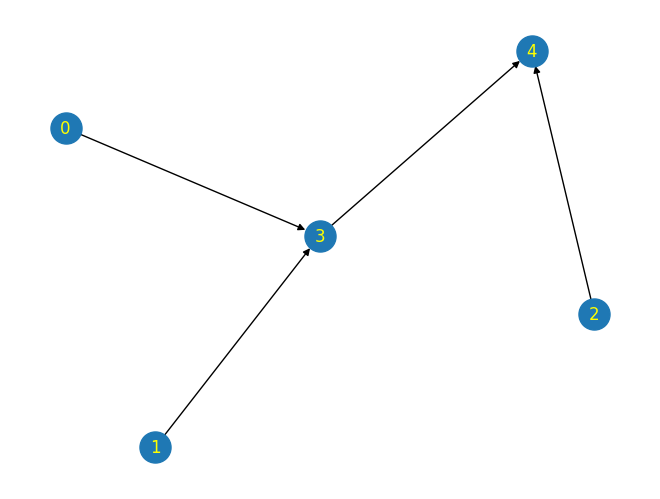

In [71]:
neat_net.plot_network(graph)

In [69]:
sigmoid(sigmoid(0.5 + 0.8) + 2)

Array(0.94190556, dtype=float32, weak_type=True)

In [67]:
sigmoid(sigmoid(0.5 + 0.8) + sigmoid(0.2))

Array(0.79177684, dtype=float32, weak_type=True)

In [65]:
updated_graph

GraphsTuple(nodes=Array([0.7310586, 0.7310586, 0.7310586, 0.7310586, 0.5      ], dtype=float32), edges=Array([1, 1, 1, 1], dtype=int32), receivers=Array([3, 3, 4, 4], dtype=int32), senders=Array([0, 1, 2, 3], dtype=int32), globals=Array([0], dtype=int32), n_node=Array([5], dtype=int32), n_edge=Array([4], dtype=int32))